
===== Test 1: Stable → Drift =====


/var/tmp/ipykernel_35278/3242571624.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)


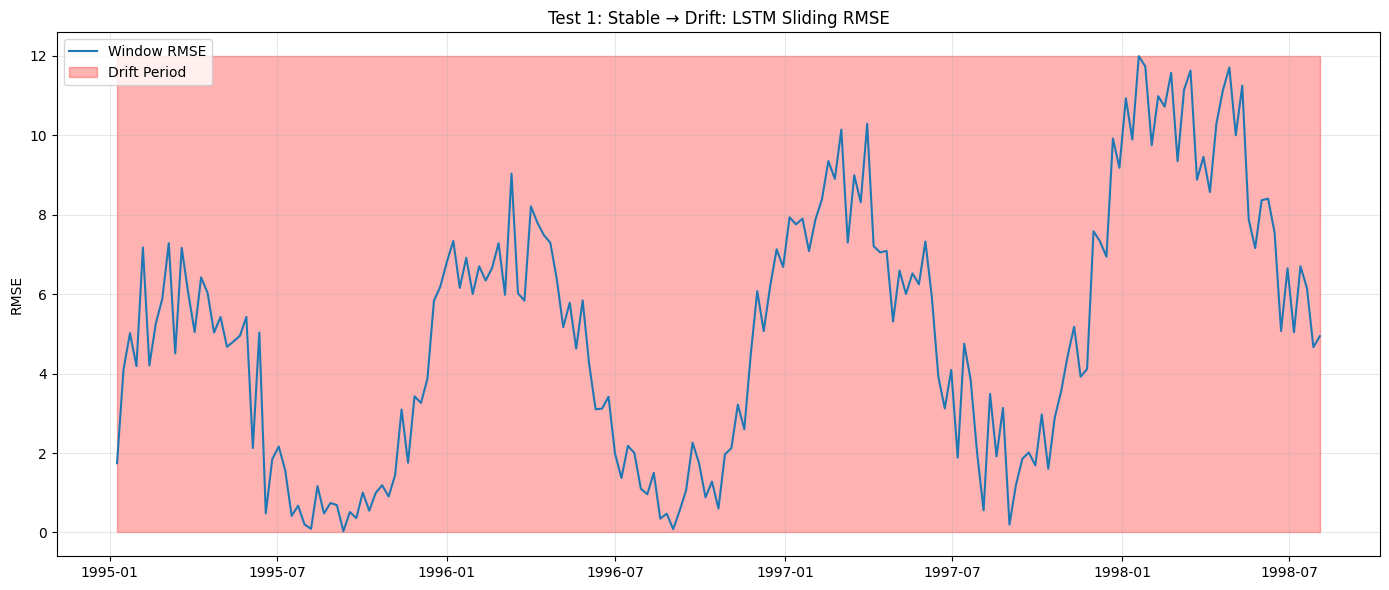

Stable RMSE: 0.726
Drift RMSE: 5.095
Robustness Ratio (Drift/Stable): 7.017

===== Test 2: Balanced Mix =====


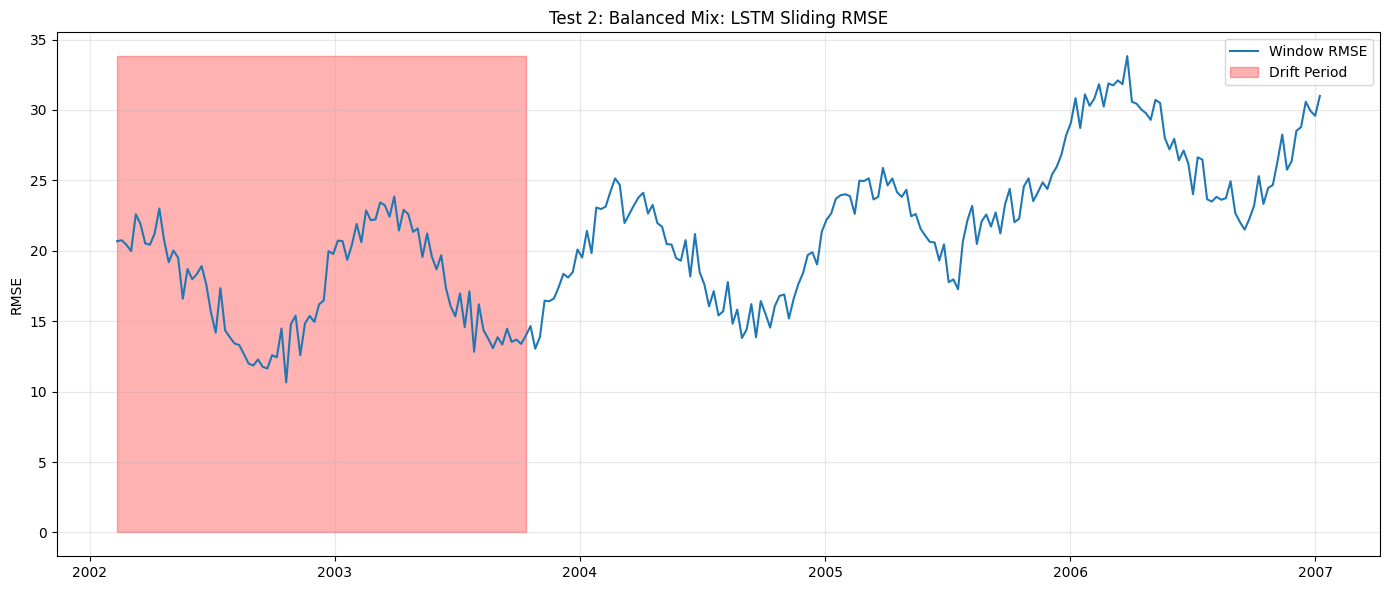

Stable RMSE: 22.927
Drift RMSE: 17.505
Robustness Ratio (Drift/Stable): 0.764

===== Test 3: Long Train, Short Inference =====


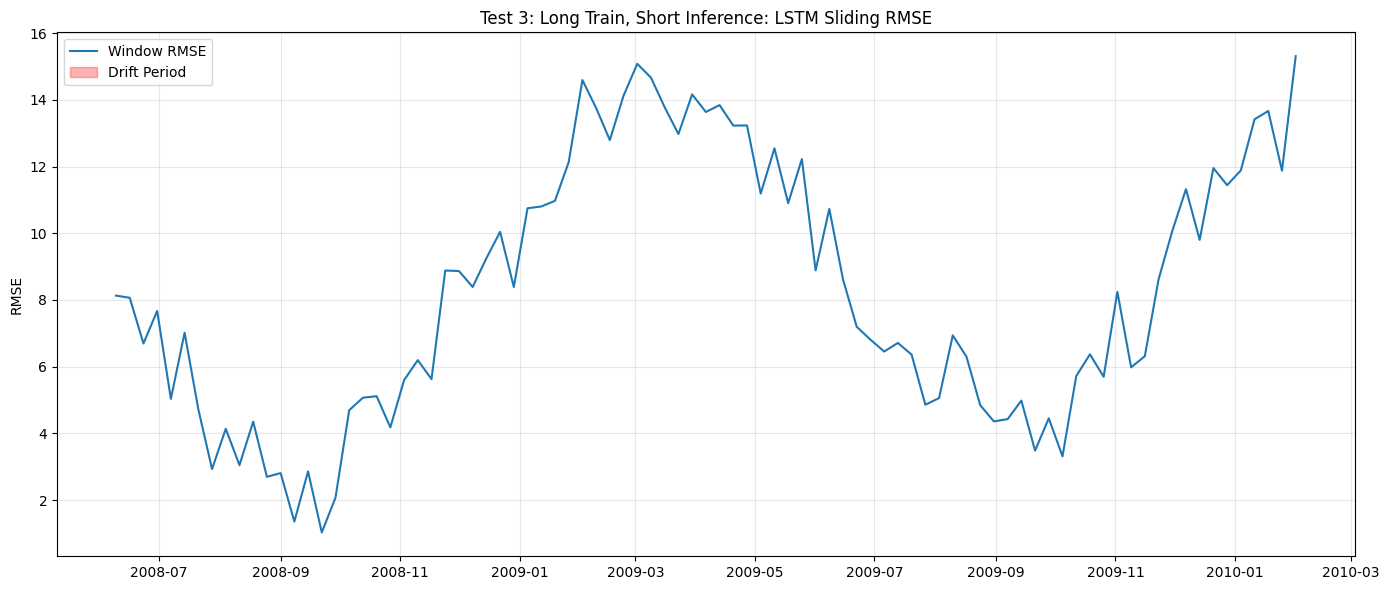

Stable RMSE: 8.262
Drift RMSE: 2.194
Robustness Ratio (Drift/Stable): 0.266

===== Test 4: Stable Only → Long Drift =====


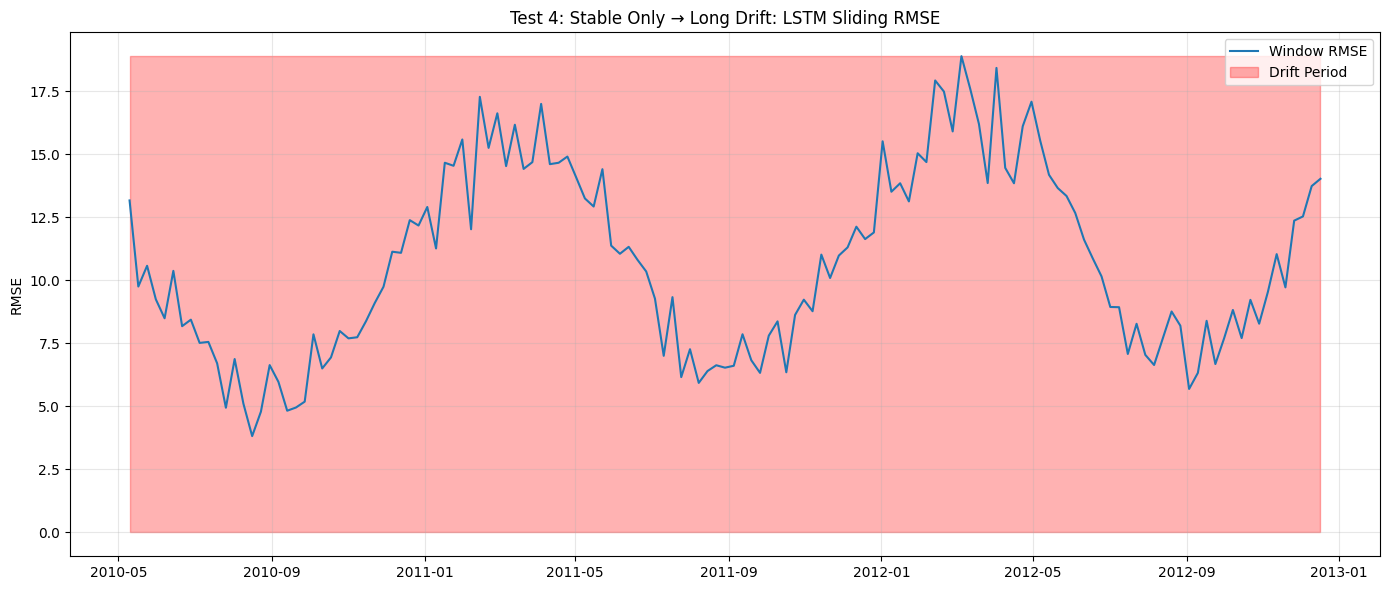

Stable RMSE: 1.494
Drift RMSE: 10.671
Robustness Ratio (Drift/Stable): 7.141

===== Test 5: Rolling Regimes =====


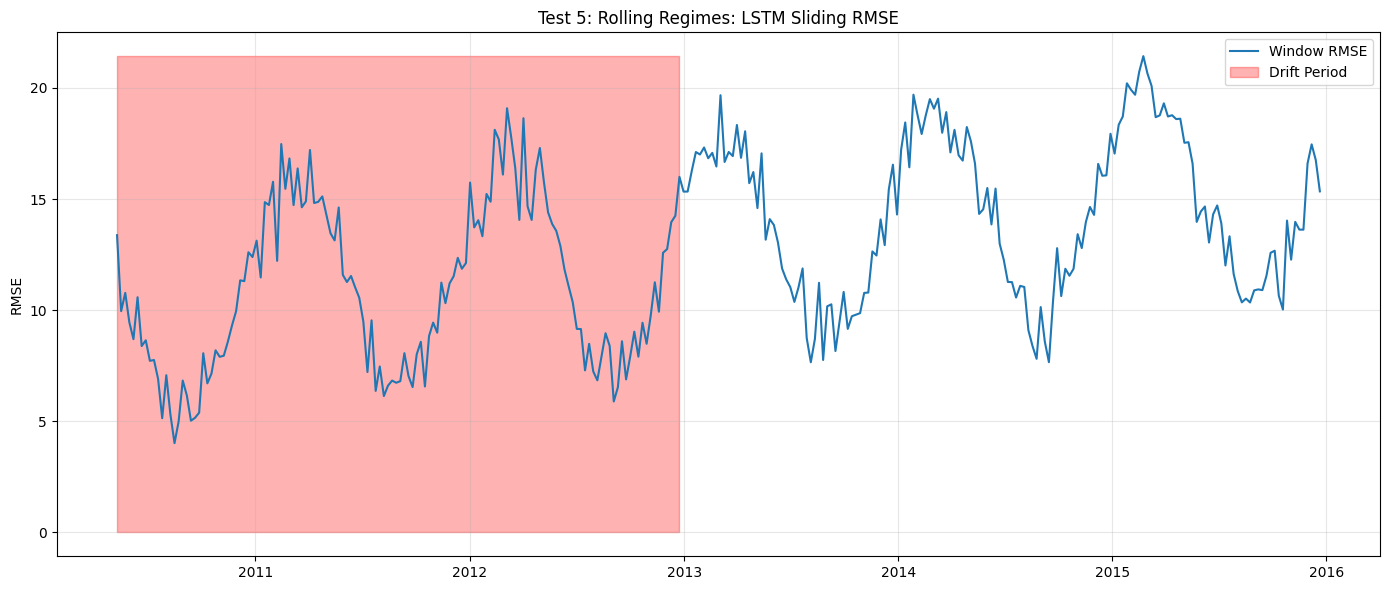

Stable RMSE: 14.394
Drift RMSE: 10.915
Robustness Ratio (Drift/Stable): 0.758


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# === Load & Prepare Data ===
df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)

# === LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

# === Sequence Prep ===
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

# === Test Runner ===
def run_lstm_test(test_name, train_start, train_end, infer_start, infer_end):
    print(f"\n===== {test_name} =====")

    target = 'var1'
    features = [col for col in df.columns if col not in [target, 'drift_period']]
    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[features])
    y_all = df[target].values
    df['scaled_idx'] = np.arange(len(df))

    train_mask = (df.index >= train_start) & (df.index <= train_end)
    infer_mask = (df.index >= infer_start) & (df.index <= infer_end)

    train_idx = df[train_mask]['scaled_idx'].astype(int).values
    infer_idx = df[infer_mask]['scaled_idx'].astype(int).values

    X_train = X_all[train_idx]
    y_train = y_all[train_idx]

    SEQ_LEN = 12
    X_seq_train, y_seq_train = create_sequences(X_train, y_train, SEQ_LEN)

    model = LSTMModel(X_seq_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_seq_train)
        loss = criterion(y_pred, y_seq_train)
        loss.backward()
        optimizer.step()

    # === Inference ===
    results = []
    for idx in range(infer_idx[0], infer_idx[-1] - SEQ_LEN):
        x_seq = torch.tensor(X_all[idx:idx+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
        y_true = y_all[idx + SEQ_LEN]
        y_pred = model(x_seq).item()
        rmse = np.sqrt((y_pred - y_true) ** 2)
        drift_flag = int(df.iloc[idx + SEQ_LEN]['drift_period'] > 0.5)
        date = df.index[idx + SEQ_LEN]
        results.append({'date': date, 'rmse': rmse, 'is_drift': drift_flag})

    results_df = pd.DataFrame(results).set_index('date')

    # === Compute RMSEs ===
    stable_rmse = results_df[results_df['is_drift'] == 0]['rmse'].mean()
    drift_rmse = results_df[results_df['is_drift'] == 1]['rmse'].mean()

    # === Fallback if either is missing ===
    if np.isnan(stable_rmse):
        stable_block = train_idx[df.iloc[train_idx]['drift_period'].values == 0]
        if len(stable_block) >= SEQ_LEN + 1:
            x_test = torch.tensor(X_all[stable_block[0]:stable_block[0]+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
            y_true = y_all[stable_block[0] + SEQ_LEN]
            y_pred = model(x_test).item()
            stable_rmse = np.sqrt((y_pred - y_true) ** 2)

    if np.isnan(drift_rmse):
        drift_block = train_idx[df.iloc[train_idx]['drift_period'].values == 1]
        if len(drift_block) >= SEQ_LEN + 1:
            x_test = torch.tensor(X_all[drift_block[0]:drift_block[0]+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
            y_true = y_all[drift_block[0] + SEQ_LEN]
            y_pred = model(x_test).item()
            drift_rmse = np.sqrt((y_pred - y_true) ** 2)

    robustness_ratio = drift_rmse / stable_rmse if stable_rmse > 0 else float('nan')

    # === Plot ===
    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Period')
    plt.title(f'{test_name}: LSTM Sliding RMSE')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Stable RMSE: {stable_rmse:.3f}")
    print(f"Drift RMSE: {drift_rmse:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")

# === Run 5 Test Cases for LSTM ===

run_lstm_test("Test 1: Stable → Drift",
              "1990-01-01", "1994-10-10",       # stable block 1
              "1994-10-17", "1998-08-10")       # drift block 1

run_lstm_test("Test 2: Balanced Mix",
              "1994-10-17", "2001-11-12",       # drift block 1 + stable block 2
              "2001-11-19", "2007-01-15")       # drift block 2 + stable block 3

run_lstm_test("Test 3: Long Train, Short Inference",
              "1990-01-01", "2008-03-10",       # up to end of drift block 3
              "2008-03-17", "2010-02-08")       # stable block 4

run_lstm_test("Test 4: Stable Only → Long Drift",
              "1990-01-01", "2010-02-08",       # all stable blocks up to block 4
              "2010-02-15", "2012-12-24")       # drift block 4

run_lstm_test("Test 5: Rolling Regimes",
              "1990-01-01", "2010-02-08",       # mixed stable/drift train
              "2010-02-15", "2015-12-28")       # drift block 4 + stable block 5

